# BM25 성능 확인

BM25를 이용하면 top-k에 따른 recall이 어느 정도 나오는지 확인
먼저 BM25을 구한다.

In [1]:
import sys, os
dir_path = os.path.dirname(os.path.abspath(''))
src_path = os.path.join(dir_path, 'src')
sys.path.append(src_path)

In [2]:
from Retrieval.sparse_retrieval import SparseRetrieval
from config import Config
from transformers import AutoTokenizer

e:\miniconda\envs\st\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config = Config(path='../config.yaml')
tokenizer = AutoTokenizer.from_pretrained(config.model.name())

e:\miniconda\envs\st\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
retriever = SparseRetrieval(tokenize_fn=tokenizer.tokenize, context_path='../data/wikipedia_documents.json')

Lengths of unique contexts : 56737


In [5]:
retriever.get_sparse_embedding()

-----------BM25 pickle loaded.-----------
-----------we loaded it from data/ not src-----------


이제 데이터셋을 불러온 후,  
top-k에 따른 recall을 구해보자.  

In [6]:
from datasets import load_from_disk
import json

In [7]:
dataset = load_from_disk('../data/train_dataset')
with open('../data/wikipedia_documents.json', 'r') as f:
    wikipedia = json.load(f)

In [8]:
train_dataset = dataset["train"]
questions = train_dataset['question']
answers = train_dataset['context']

In [9]:
_, doc_indices = retriever.get_relevant_doc_bulk(questions, k=100)

get_relevant_doc_bulk실행중 queries의 개수는  3952
get_relevant_doc_bulk실행중 queries의 type은  <class 'list'>


Processing queries: 100%|██████████| 3952/3952 [25:29<00:00,  2.58it/s]


In [ ]:
rankings = []
for i, indices in enumerate(doc_indices):
    in_k = False
    for rank, idx in enumerate(indices):
        if retriever.contexts[idx] == answers[i]:
            in_k = True
            rankings.append(rank+1)
            break
    if not in_k:
        rankings.append(len(indices)+1)

In [11]:
def recall_at_k(k, rankings):
    return sum([1 for rank in rankings if rank <= k]) / len(rankings)

In [12]:
recalls = [recall_at_k(k, rankings) for k in range(1, 101)]

lineplot으로 시각화 진행

In [13]:
import matplotlib as mpt
import matplotlib.pyplot as plt

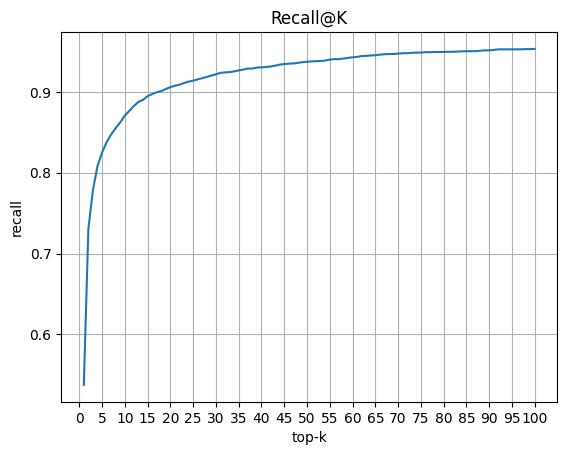

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1, 101), recalls)
ax.set_xlabel('top-k')
ax.set_ylabel('recall')
ax.set_xticks(range(0, 101, 5))
ax.set_title('Recall@K')
ax.grid()

In [15]:
print("recall @ 1 :", recalls[0])
target_recall = (int(recalls[0] * 100)//10 + 1) * 10
for i in range(1, 100):
    check = False
    if recalls[i] >= target_recall/100:
        print("recall @", i+1, ":", recalls[i])
        target_recall += 10
        check = True
    if not check and i <= 4:
        print("recall @", i+1, ":", recalls[i])
print("recall @ 25 :", recalls[24])
print("recall @ 100 :", recalls[99])

recall @ 1 : 0.5374493927125507
recall @ 2 : 0.7305161943319838
recall @ 3 : 0.7785931174089069
recall @ 4 : 0.8081983805668016
recall @ 5 : 0.8248987854251012
recall @ 18 : 0.9010627530364372
recall @ 25 : 0.9139676113360324
recall @ 100 : 0.9531882591093117
